In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, mean
from pyspark.ml.feature import StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA as PCAml
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, lit, to_date, when, count



In [11]:
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

In [12]:
# Load dataset (replace 'customer_data.csv' with actual path)
df = spark.read.csv("customer_segmentation_data.csv", header=True, inferSchema=True)

# Display schema and first few rows
df.printSchema()
df.show(5)

root
 |-- cif_id: string (nullable = true)
 |-- nepali_fiscal_year: string (nullable = true)
 |-- schm_type: string (nullable = true)
 |-- dr_tran_volume: double (nullable = true)
 |-- cr_tran_volume: double (nullable = true)
 |-- dr_month_count: integer (nullable = true)
 |-- cr_month_count: integer (nullable = true)
 |-- total_debit_transaction: integer (nullable = true)
 |-- total_credit_transaction: integer (nullable = true)
 |-- total_yearly_saving: double (nullable = true)
 |-- cif_id__1: string (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- age_group: string (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- salary_per_month: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- total_credit_withdrawal_volume: double (nullable = true)
 |-- withdrawal_volume: string (nullable = true)
 |-- total_accounts: 

In [13]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import col, lit, to_date, when, count

# # Check DataFrame Schema
# df.printSchema()

# # List of numerical and categorical columns
# numerical_columns = [col_name for col_name, dtype in df.dtypes if dtype in ('int', 'double')]
# categorical_columns = ['employment_status', 'marital_status', 'occupation', 'gender', 
#                       'age_group', 'scheme_type', 'Recently_Active']

# # # Ensure only existing categorical columns are processed
# categorical_columns = [col for col in categorical_columns if col in df.columns]

# # Fill missing numerical values with median
# for col_name in numerical_columns:
#     if col_name in df.columns:  # Ensure column exists
#         median_value = df.approxQuantile(col_name, [0.5], 0.25)[0]
#         if median_value is not None:
#             df = df.fillna({col_name: median_value})

# # Fill missing categorical values with mode
# for col_name in categorical_columns:
#     non_null_count = df.filter(col(col_name).isNotNull()).count()
#     if non_null_count > 0:
#         mode_row = df.groupby(col_name).count().orderBy(col("count").desc()).first()
#         if mode_row:  # Ensure mode value is not None
#             mode_value = mode_row[0]
#             df = df.fillna({col_name: mode_value})
#     else:
#         df = df.withColumn(col_name, lit("UNKNOWN"))

# # Handle date columns
# date_columns = [col_name for col_name, dtype in df.dtypes if dtype == 'date']
# for col_name in date_columns:
#     df = df.withColumn(col_name, when(col(col_name).isNull(), to_date(lit("2023-01-01"))).otherwise(col(col_name)))

# # Show missing values after processing
# df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# # Show final DataFrame
# df.show()


In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, to_date, when, count

# Check for missing values
def check_null(c):
    return count(when(col(c).isNull(), c))

df.select([check_null(c).alias(c) for c in df.columns]).show()

# # Ensure we only process columns that exist in DataFrame
numerical_columns = [col_name for col_name, dtype in df.dtypes if dtype in ('int', 'double') and col_name in df.columns]
categorical_columns = ['employment_status', 'marital_status', 'occupation', 'gender', 
                      'age_group', 'scheme_type', 'Recently_Active']

# # Remove non-existent categorical columns
categorical_columns = [col for col in categorical_columns if col in df.columns]

# # Fill missing numerical values with median safely
for col_name in numerical_columns:
    if df.filter(col(col_name).isNotNull()).count() > 0:  # Ensure the column is not entirely null
        median_value = df.approxQuantile(col_name, [0.5], 0.25)[0]
        if median_value is not None:
            df = df.fillna({col_name: median_value})

# # Fill missing categorical values with mode safely
for col_name in categorical_columns:
    non_null_count = df.filter(col(col_name).isNotNull()).count()
    if non_null_count > 0:
        mode_row = df.groupby(col_name).count().orderBy(col("count").desc()).first()
        if mode_row and mode_row[0] is not None:  # Ensure mode_row is valid
            mode_value = mode_row[0]  # Get the most frequent category
        else:
            mode_value = "UNKNOWN"  # Default if mode cannot be determined
        df = df.fillna({col_name: mode_value})
    else:
        df = df.withColumn(col_name, lit("UNKNOWN"))

# # Handle date columns separately
date_columns = [col_name for col_name, dtype in df.dtypes if dtype == 'date' and col_name in df.columns]
default_date = "2023-01-01"  # Choose an appropriate default date

for col_name in date_columns:
    df = df.withColumn(col_name, when(col(col_name).isNull(), to_date(lit(default_date))).otherwise(col(col_name)))

# # Show final DataFrame after missing value handling
df.show()


+------+------------------+---------+--------------+--------------+--------------+--------------+-----------------------+------------------------+-------------------+---------+----------+---+---------+-----------------+--------------+----------+----------------+------+------------------------------+-----------------+--------------+---------------------+--------------------+-------------------+------------------------+
|cif_id|nepali_fiscal_year|schm_type|dr_tran_volume|cr_tran_volume|dr_month_count|cr_month_count|total_debit_transaction|total_credit_transaction|total_yearly_saving|cif_id__1|birth_year|age|age_group|employment_status|marital_status|occupation|salary_per_month|gender|total_credit_withdrawal_volume|withdrawal_volume|total_accounts|total_saving_accounts|total_fixed_accounts|total_loan_accounts|total_overdraft_accounts|
+------+------------------+---------+--------------+--------------+--------------+--------------+-----------------------+------------------------+----------

In [15]:
# from pyspark.ml.feature import StringIndexer, OneHotEncoder
# from pyspark.sql.functions import col

# # Check the number of distinct values for each categorical column
# for column in categorical_columns:
#     distinct_count = df.select(column).distinct().count()
#     print(f"Column {column} has {distinct_count} distinct values")

# # Filter categorical columns that have at least 2 distinct values
# valid_categorical_columns = []
# for column in categorical_columns:
#     distinct_count = df.select(column).distinct().count()
#     if distinct_count >= 2:
#         valid_categorical_columns.append(column)

# print(f"Columns with at least 2 distinct values: {valid_categorical_columns}")

# # Only apply encoding to valid columns
# if valid_categorical_columns:
#     # Create and apply StringIndexers
#     indexers = [StringIndexer(inputCol=col_name, outputCol=col_name+"_index", handleInvalid="keep") 
#                 for col_name in valid_categorical_columns]
    
#     for indexer in indexers:
#         df = indexer.fit(df).transform(df)
    
#     # Create and apply OneHotEncoder
#     encoder = OneHotEncoder(inputCols=[col_name+"_index" for col_name in valid_categorical_columns], 
#                             outputCols=[col_name+"_encoded" for col_name in valid_categorical_columns])
    
#     df = encoder.fit(df).transform(df)
# else:
#     print("No categorical columns have enough distinct values for encoding.")

# working categorical

In [16]:
# # Filter categorical columns that have at least 2 distinct values
# valid_categorical_columns = []
# for column in categorical_columns:
#     distinct_count = df.select(column).distinct().count()
#     print(f"Column {column} has {distinct_count} distinct values")
#     if distinct_count >= 2:
#         valid_categorical_columns.append(column)

# print(f"Columns with at least 2 distinct values: {valid_categorical_columns}")

# # Only apply encoding to valid columns
# indexed_columns = []
# encoded_columns = []

# if valid_categorical_columns:
#     # Create and apply StringIndexers
#     for col_name in valid_categorical_columns:
#         indexer = StringIndexer(inputCol=col_name, outputCol=col_name+"_index", handleInvalid="keep")
#         df = indexer.fit(df).transform(df)
#         indexed_columns.append(col_name+"_index")
    
#     # Create and apply OneHotEncoder
#     if indexed_columns:
#         encoder = OneHotEncoder(inputCols=indexed_columns, 
#                                 outputCols=[col_name+"_encoded" for col_name in valid_categorical_columns])
#         df = encoder.fit(df).transform(df)
#         encoded_columns = [col_name+"_encoded" for col_name in valid_categorical_columns]

Column employment_status has 7 distinct values
Column marital_status has 3 distinct values
Column occupation has 10 distinct values
Column gender has 2 distinct values
Column age_group has 5 distinct values
Columns with at least 2 distinct values: ['employment_status', 'marital_status', 'occupation', 'gender', 'age_group']
Feature columns: ['dr_tran_volume', 'cr_tran_volume', 'dr_month_count', 'cr_month_count', 'total_debit_transaction', 'total_credit_transaction', 'total_yearly_saving', 'birth_year', 'age', 'salary_per_month', 'total_credit_withdrawal_volume', 'total_accounts', 'total_saving_accounts', 'total_fixed_accounts', 'total_loan_accounts', 'total_overdraft_accounts', 'prediction', 'employment_status_index', 'marital_status_index', 'occupation_index', 'gender_index', 'age_group_index', 'employment_status_encoded', 'marital_status_encoded', 'occupation_encoded', 'gender_encoded', 'age_group_encoded']
k=2, WCSS=43496.28473637425, Silhouette=0.20525004305729172
k=3, WCSS=41209.86

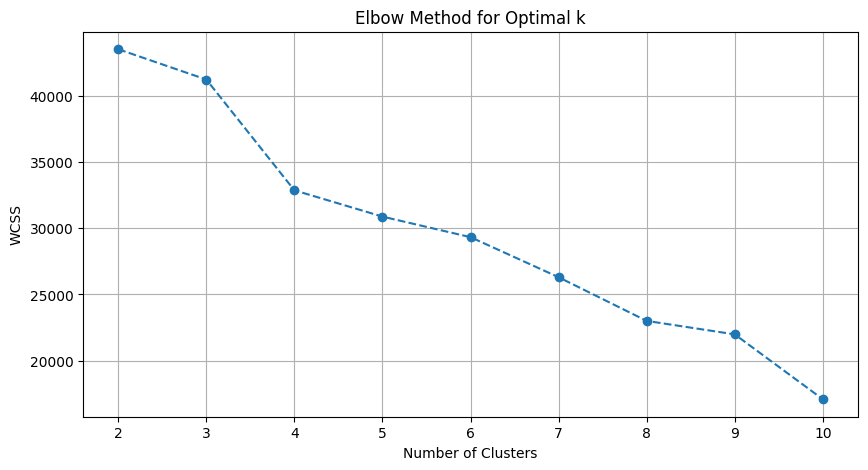

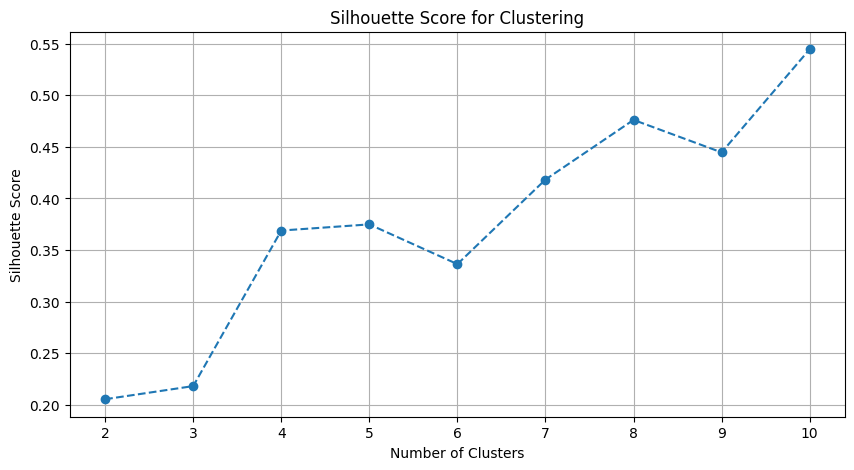

+--------------+-------+
|        cif_id|Cluster|
+--------------+-------+
|DLNINDV1034377|      5|
|DLNINDV1034377|      5|
|DLNINDV1034377|      5|
|DLNINDV1034377|      5|
|DLNINDV1034377|      5|
|DLNINDV1034377|      5|
|DLNINDV1034377|      5|
|DLNINDV1034377|      5|
|DLNINDV1034377|      5|
|DLNINDV1034377|      5|
+--------------+-------+
only showing top 10 rows



In [22]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd
import matplotlib.pyplot as plt

# # Step 1: Filter categorical columns that have at least 2 distinct values
valid_categorical_columns = []
for column in categorical_columns:
    distinct_count = df.select(column).distinct().count()
    print(f"Column {column} has {distinct_count} distinct values")
    if distinct_count >= 2:
        valid_categorical_columns.append(column)

print(f"Columns with at least 2 distinct values: {valid_categorical_columns}")

# # Step 2: Apply StringIndexer and OneHotEncoder for categorical columns
indexed_columns = []
encoded_columns = []

# # Fix: Drop existing index & encoded columns before creating new ones
for col_name in valid_categorical_columns:
    index_col = col_name + "_index"
    encoded_col = col_name + "_encoded"

    if index_col in df.columns:
        df = df.drop(index_col)
    if encoded_col in df.columns:
        df = df.drop(encoded_col)

# Apply StringIndexer
for col_name in valid_categorical_columns:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name+"_index", handleInvalid="keep")
    df = indexer.fit(df).transform(df)
    indexed_columns.append(col_name+"_index")

# Apply OneHotEncoder
if indexed_columns:
    encoder = OneHotEncoder(inputCols=indexed_columns, 
                            outputCols=[col_name+"_encoded" for col_name in valid_categorical_columns])
    df = encoder.fit(df).transform(df)
    encoded_columns = [col_name+"_encoded" for col_name in valid_categorical_columns]

#  Step 3: Scale numerical columns using StandardScaler
numerical_columns = [col_name for col_name, dtype in df.dtypes if dtype in ('int', 'double') and col_name in df.columns]

# # Step 4: Assemble numerical and encoded categorical features into a single vector
feature_columns = numerical_columns + encoded_columns
print(f"Feature columns: {feature_columns}")

# Ensure we have features to work with
if len(feature_columns) == 0:
    raise ValueError("No feature columns available for clustering")

# # Fix: Drop existing "features" column if it exists
if "features" in df.columns:
    df = df.drop("features")

# # Create the vector assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
df = assembler.transform(df)

# # Fix: Drop existing "scaled_features" column if it exists
if "scaled_features" in df.columns:
    df = df.drop("scaled_features")

# # Standardizing numerical features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# # Fix: Drop existing "prediction" column before running KMeans
if "prediction" in df.columns:
    df = df.drop("prediction")

# # Evaluate different numbers of clusters using the Elbow Method & Silhouette Score
wcss = []  # Within-Cluster Sum of Squares
silhouette_scores = []

for k in range(2, 11):  # Checking for 2 to 10 clusters
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans.fit(df)
    predictions = model.transform(df)
    
    # Calculate silhouette score
    evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="scaled_features", metricName="silhouette")
    silhouette_score = evaluator.evaluate(predictions)
    
    wcss.append(model.summary.trainingCost)
    silhouette_scores.append(silhouette_score)
    print(f"k={k}, WCSS={model.summary.trainingCost}, Silhouette={silhouette_score}")

# # Convert to Pandas for plotting
elbow_df = pd.DataFrame({'Clusters': range(2, 11), 'WCSS': wcss, 'Silhouette': silhouette_scores})

# # Plot Elbow Method
plt.figure(figsize=(10,5))
plt.plot(elbow_df['Clusters'], elbow_df['WCSS'], marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# # Plot Silhouette Score
plt.figure(figsize=(10,5))
plt.plot(elbow_df['Clusters'], elbow_df['Silhouette'], marker='o', linestyle='--')
plt.title('Silhouette Score for Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# # Step 5: Final Clustering with Optimal k
optimal_k = elbow_df.loc[elbow_df['Silhouette'].idxmax(), 'Clusters']  # Select k with the highest silhouette score
kmeans = KMeans(featuresCol="scaled_features", k=int(optimal_k), seed=42)
final_model = kmeans.fit(df)
df = final_model.transform(df)

# # Step 6: Rename "prediction" to "Cluster"
df = df.withColumnRenamed("prediction", "Cluster")

# # Step 7: Show results
df.select("cif_id", "Cluster").show(10)


In [17]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

# # Step 1: Filter categorical columns that have at least 2 distinct values
valid_categorical_columns = []
for column in categorical_columns:
    distinct_count = df.select(column).distinct().count()
    print(f"Column {column} has {distinct_count} distinct values")
    if distinct_count >= 2:
        valid_categorical_columns.append(column)

print(f"Columns with at least 2 distinct values: {valid_categorical_columns}")

# # Step 2: Apply StringIndexer and OneHotEncoder for categorical columns
indexed_columns = []
encoded_columns = []

if valid_categorical_columns:
    # Apply StringIndexer
    for col_name in valid_categorical_columns:
        indexer = StringIndexer(inputCol=col_name, outputCol=col_name+"_index", handleInvalid="keep")
        df = indexer.fit(df).transform(df)
        indexed_columns.append(col_name+"_index")
    
    # Apply OneHotEncoder
    if indexed_columns:
        encoder = OneHotEncoder(inputCols=indexed_columns, 
                                outputCols=[col_name+"_encoded" for col_name in valid_categorical_columns])
        df = encoder.fit(df).transform(df)
        encoded_columns = [col_name+"_encoded" for col_name in valid_categorical_columns]

# # Step 3: Scale numerical columns using StandardScaler
numerical_columns = [col_name for col_name, dtype in df.dtypes if dtype in ('int', 'double') and col_name in df.columns]

# Assemble numerical columns into a single feature vector
numerical_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")
df = numerical_assembler.transform(df)

# Apply StandardScaler
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features", withMean=True, withStd=True)
df = scaler.fit(df).transform(df)

# # Step 4: Combine categorical & numerical features
feature_columns = encoded_columns + ["scaled_numerical_features"]

# Assemble all features into a single vector column
final_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = final_assembler.transform(df)

# # Step 5: Apply K-Means Clustering
kmeans = KMeans(featuresCol="features", k=5, seed=42)  # Choose k based on elbow method
model = kmeans.fit(df)
df = model.transform(df)

# # Step 6: Show results
# df.select("cif_id", "Cluster").show(10)
df.withColumnRenamed("prediction", "Cluster").select("cif_id", "Cluster").show(10)



Column employment_status has 7 distinct values
Column marital_status has 3 distinct values
Column occupation has 10 distinct values
Column gender has 2 distinct values
Column age_group has 5 distinct values
Columns with at least 2 distinct values: ['employment_status', 'marital_status', 'occupation', 'gender', 'age_group']
+--------------+-------+
|        cif_id|Cluster|
+--------------+-------+
|DLNINDV1034377|      0|
|DLNINDV1034377|      0|
|DLNINDV1034377|      0|
|DLNINDV1034377|      0|
|DLNINDV1034377|      0|
|DLNINDV1034377|      0|
|DLNINDV1034377|      0|
|DLNINDV1034377|      0|
|DLNINDV1034377|      0|
|DLNINDV1034377|      0|
+--------------+-------+
only showing top 10 rows



In [ ]:
# # Choose the optimal number of clusters based on the Elbow & Silhouette methods
# # For this example, I'm assuming 5 is optimal, but you should adjust based on the plots
# optimal_k = 6  # Change based on your results

# # Apply final KMeans model
# kmeans = KMeans(featuresCol="scaled_features", k=optimal_k, seed=42)
# model = kmeans.fit(df)
# df = model.transform(df)

# # Rename 'prediction' column to 'Cluster' for clarity
# df = df.withColumnRenamed("prediction", "Cluster")

# # Show cluster counts
# cluster_counts = df.groupBy("Cluster").count().orderBy("Cluster")
# cluster_counts.show()

In [24]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col

# Choose the optimal number of clusters based on the Elbow & Silhouette methods
optimal_k = 10  # Adjusted based on your results

# Apply the final KMeans model
kmeans = KMeans(featuresCol="scaled_features", k=optimal_k, seed=42)
model = kmeans.fit(df)
df = model.transform(df)

# Ensure there is no duplicate 'Cluster' column
if "Cluster" in df.columns:
    df = df.drop("Cluster")

# Rename 'prediction' column to 'Cluster'
df = df.withColumnRenamed("prediction", "Cluster")

# Show cluster counts
cluster_counts = df.groupBy("Cluster").count().orderBy("Cluster")
cluster_counts.show()

# Display cluster centroids
centers = model.clusterCenters()
for i, center in enumerate(centers):
    print(f"Cluster {i} Centroid: {center}")


# Show cluster counts
cluster_counts = df.groupBy("Cluster").count().orderBy("Cluster")
cluster_counts.show()

# Display cluster centroids
centers = model.clusterCenters()
for i, center in enumerate(centers):
    print(f"Cluster {i} Centroid: {center}")


+-------+-----+
|Cluster|count|
+-------+-----+
|      0|   12|
|      1|   48|
|      2|  364|
|      3|   36|
|      4|   12|
|      5|  120|
|      6|  176|
|      7|   48|
|      8|   80|
|      9|  104|
+-------+-----+

Cluster 0 Centroid: [-0.20148296 -0.24764347  1.849822    0.89590126 -0.22267266 -0.4213929
  0.0427494   2.90834739 -2.90834739 -0.37015865 -0.63724977 -0.59915783
  0.12166571 -0.57193345 -0.76582403 -0.63895746  1.39114432  3.31048892
 -0.81323929  3.04797488  1.12758793  3.42685671 -0.99949987 -0.51221444
 -0.51221444 -0.19315034 -0.16964014  9.06923371 -0.08975774  0.90043468
 -0.66681453 -0.40327151 -0.71099794 -0.46192926 -0.40994643 -0.34778608
 -0.31047502 -0.22443206 -0.19315034 -0.16964014 -0.15673409  9.06923371
 -1.12758793  1.12758793 -1.10053487 -0.54317718 -0.46192926 -0.19315034
  9.06923371]
Cluster 1 Centroid: [ 0.87896694  1.29396507 -0.00796193 -0.39184183 -0.2586224  -0.38358625
 -0.08761575 -0.87200017  0.87200017 -0.56002254  1.57809741  1.6

In [25]:
pip install seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


25/03/12 09:04:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


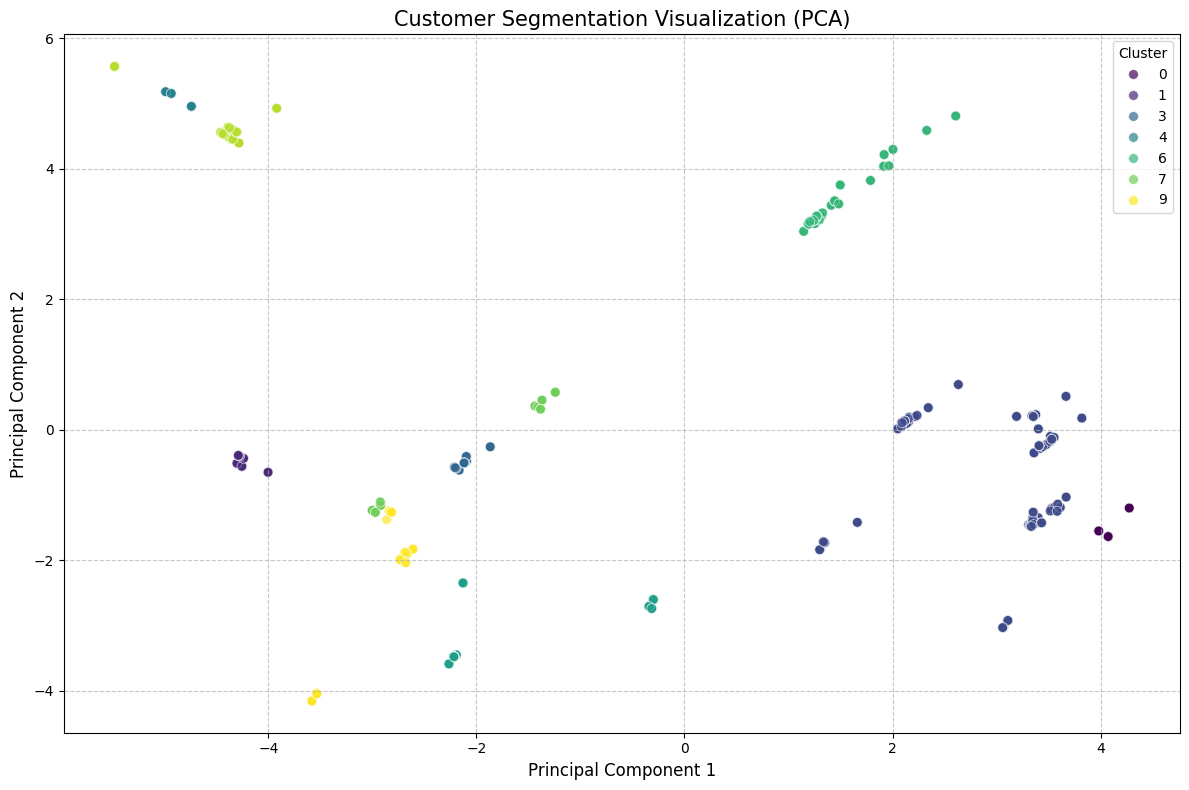

In [26]:
from pyspark.ml.feature import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Check if 'pca_features' column exists and drop it before applying PCA
if "pca_features" in df.columns:
    df = df.drop("pca_features")

# Apply PCA for dimensionality reduction
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df)
df = pca_model.transform(df)

# Extract PCA components for visualization
df_pca = df.select("pca_features", "Cluster").toPandas()
df_pca['PCA1'] = df_pca['pca_features'].apply(lambda x: float(x[0]))
df_pca['PCA2'] = df_pca['pca_features'].apply(lambda x: float(x[1]))

# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue="Cluster", palette="viridis", s=50, alpha=0.7)
plt.title("Customer Segmentation Visualization (PCA)", fontsize=15)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [28]:
from pyspark.sql.functions import col, mean, count, lit

# Ensure `numerical_columns` only contains valid columns from the DataFrame
valid_numerical_columns = [col_name for col_name in numerical_columns if col_name in df.columns]

# Debugging: Print available columns and valid numerical columns
print("Columns in DataFrame:", df.columns)
print("Numerical columns provided:", numerical_columns)
print("Valid numerical columns used:", valid_numerical_columns)

# Generate numerical features profile per cluster
numerical_profile = df.groupBy("Cluster").agg(
    *[mean(col(column)).alias(column) for column in valid_numerical_columns]
).orderBy("Cluster")

# Convert to Pandas for easy viewing
numerical_profile_pd = numerical_profile.toPandas()
print("\nNumerical Features Profile by Cluster:")
print(numerical_profile_pd)

# Generate categorical features profile per cluster
categorical_profiles = {}

# Compute total counts per cluster
cluster_totals = df.groupBy("Cluster").count().withColumnRenamed("count", "total")

# Ensure valid categorical columns
valid_categorical_columns = [col_name for col_name in valid_categorical_columns if col_name in df.columns]

for cat_col in valid_categorical_columns:
    profile = (
        df.groupBy("Cluster", cat_col)
        .count()
        .join(cluster_totals, on="Cluster", how="left")  # Ensure total count is available
        .withColumn("percentage", (col("count") / col("total")) * 100)
        .orderBy("Cluster", col("percentage").desc())
    )
    
    categorical_profiles[cat_col] = profile

# Display categorical distributions (Top 3 categories per cluster)
for cat_col, profile in categorical_profiles.items():
    print(f"\n🔹 Top categories for {cat_col} by cluster:")
    
    for cluster_id in range(optimal_k):
        top_categories = (
            profile.filter(col("Cluster") == cluster_id)
            .orderBy(col("percentage").desc())
            .limit(3)
            .toPandas()
        )
        print(f"\nCluster {cluster_id}:")
        print(top_categories[["Cluster", cat_col, "count", "percentage"]])


Columns in DataFrame: ['cif_id', 'nepali_fiscal_year', 'schm_type', 'dr_tran_volume', 'cr_tran_volume', 'dr_month_count', 'cr_month_count', 'total_debit_transaction', 'total_credit_transaction', 'total_yearly_saving', 'cif_id__1', 'birth_year', 'age', 'age_group', 'employment_status', 'marital_status', 'occupation', 'salary_per_month', 'gender', 'total_credit_withdrawal_volume', 'withdrawal_volume', 'total_accounts', 'total_saving_accounts', 'total_fixed_accounts', 'total_loan_accounts', 'total_overdraft_accounts', 'numerical_features', 'scaled_numerical_features', 'employment_status_index', 'marital_status_index', 'occupation_index', 'gender_index', 'age_group_index', 'employment_status_encoded', 'marital_status_encoded', 'occupation_encoded', 'gender_encoded', 'age_group_encoded', 'features', 'scaled_features', 'Cluster', 'pca_features']
Numerical columns provided: ['dr_tran_volume', 'cr_tran_volume', 'dr_month_count', 'cr_month_count', 'total_debit_transaction', 'total_credit_transa


Cluster 0:
   Cluster marital_status  count  percentage
0        0      UNMARRIED     12       100.0



Cluster 1:
   Cluster marital_status  count  percentage
0        1        MARRIED     48       100.0

Cluster 2:
   Cluster marital_status  count  percentage
0        2      UNMARRIED    328    90.10989
1        2        MARRIED     36     9.89011

Cluster 3:
   Cluster marital_status  count  percentage
0        3      UNMARRIED     36       100.0



Cluster 4:
   Cluster marital_status  count  percentage
0        4         OTHERS     12       100.0

Cluster 5:
   Cluster marital_status  count  percentage
0        5        MARRIED    120       100.0

Cluster 6:
   Cluster marital_status  count  percentage
0        6      UNMARRIED    176       100.0

Cluster 7:
   Cluster marital_status  count  percentage
0        7         OTHERS     48       100.0



Cluster 8:
   Cluster marital_status  count  percentage
0        8         OTHERS     80       100.0

Cluster 9:
   Cluster marital_status  count  percentage
0        9        MARRIED    104       100.0

🔹 Top categories for occupation by cluster:



Cluster 0:
   Cluster  occupation  count  percentage
0        0  UNEMPLOYED     12       100.0

Cluster 1:
   Cluster occupation  count  percentage
0        1    TEACHER     48       100.0

Cluster 2:
   Cluster occupation  count  percentage
0        2    SERVICE    336   92.307692
1        2    STUDENT     28    7.692308



Cluster 3:
   Cluster occupation  count  percentage
0        3   ENGINEER     36       100.0

Cluster 4:
   Cluster occupation  count  percentage
0        4  HOUSEWIFE     12       100.0

Cluster 5:
   Cluster     occupation  count  percentage
0        5  SELF-EMPLOYED     88   73.333333
1        5    BUSINESSMAN     24   20.000000
2        5      HOUSEWIFE      8    6.666667

Cluster 6:
   Cluster occupation  count  percentage
0        6     BANKER    176       100.0

Cluster 7:
   Cluster     occupation  count  percentage
0        7  NOT AVAILABLE     24        50.0
1        7    BUSINESSMAN     24        50.0

Cluster 8:
   Cluster occupation  count  percentage
0        8  HOUSEWIFE     80       100.0

Cluster 9:
   Cluster   occupation  count  percentage
0        9  BUSINESSMAN     96   92.307692
1        9    HOUSEWIFE      8    7.692308

🔹 Top categories for gender by cluster:

Cluster 0:
   Cluster gender  count  percentage
0        0      M     12       100.0

Cluster 1:
   Cl


Cluster 2:
   Cluster age_group  count  percentage
0        2     Gen Z    204   56.043956
1        2     Gen Y    160   43.956044



Cluster 3:
   Cluster     age_group  count  percentage
0        3  Baby Boomers     36       100.0



Cluster 4:
   Cluster age_group  count  percentage
0        4     Gen Y     12       100.0

Cluster 5:
   Cluster age_group  count  percentage
0        5     Gen Y     96        80.0
1        5     Gen Z     24        20.0



Cluster 6:
   Cluster age_group  count  percentage
0        6     Gen Y    176       100.0

Cluster 7:
   Cluster age_group  count  percentage
0        7     Gen X     24        50.0
1        7     Gen Y     24        50.0



Cluster 8:
   Cluster age_group  count  percentage
0        8     Gen Y     80       100.0

Cluster 9:
   Cluster age_group  count  percentage
0        9     Gen X    104       100.0


In [29]:
# Create a cluster interpretation summary
def interpret_clusters(numerical_profile, cluster_counts):
    """Generate business interpretation of clusters based on their profiles"""
    cluster_interpretation = {}
    
    for cluster_id in range(optimal_k):
        # Filter profile for this cluster
        cluster_profile = numerical_profile_pd[numerical_profile_pd["Cluster"] == cluster_id]
        
        # Get cluster size
        cluster_size = cluster_counts.filter(col("Cluster") == cluster_id).collect()[0]["count"]
        
        # Start with basic description
        interpretation = f"Cluster {cluster_id} - {cluster_size} customers\n"
        
        # Add key metrics to interpretation
        # Customize these based on your domain knowledge and numerical_columns
        if "average_yearly_saving" in numerical_columns:
            avg_saving = cluster_profile["average_yearly_saving"].values[0]
            if avg_saving > (numerical_profile_pd["average_yearly_saving"].mean() * 1.5):
                interpretation += "- High savers\n"
            elif avg_saving < (numerical_profile_pd["average_yearly_saving"].mean() * 0.5):
                interpretation += "- Low savers\n"
        
        if "total_accounts" in numerical_columns:
            accounts = cluster_profile["total_accounts"].values[0]
            if accounts > (numerical_profile_pd["total_accounts"].mean() * 1.2):
                interpretation += "- Multiple account holders\n"
            elif accounts < (numerical_profile_pd["total_accounts"].mean() * 0.8):
                interpretation += "- Single account holders\n"
        
        # Add more interpretations based on other columns
        
        cluster_interpretation[cluster_id] = interpretation
    
    return cluster_interpretation

# Generate and print interpretations
interpretations = interpret_clusters(numerical_profile_pd, cluster_counts)
print("\nCluster Business Interpretations:")
for cluster_id, interpretation in interpretations.items():
    print(interpretation)
    print("-" * 40)


Cluster Business Interpretations:
Cluster 0 - 12 customers
- Single account holders

----------------------------------------
Cluster 1 - 48 customers
- Multiple account holders

----------------------------------------
Cluster 2 - 364 customers
- Single account holders

----------------------------------------
Cluster 3 - 36 customers

----------------------------------------
Cluster 4 - 12 customers
- Multiple account holders

----------------------------------------
Cluster 5 - 120 customers
- Single account holders

----------------------------------------
Cluster 6 - 176 customers
- Single account holders

----------------------------------------
Cluster 7 - 48 customers
- Single account holders

----------------------------------------
Cluster 8 - 80 customers
- Multiple account holders

----------------------------------------
Cluster 9 - 104 customers
- Single account holders

----------------------------------------


In [32]:
from pyspark.sql.functions import col, mean, max, min, sum, count
import pandas as pd
import builtins as bt  # Avoids conflicts with PySpark functions

def create_cluster_profiles(df, numerical_columns, categorical_columns, cluster_counts):
    """
    Create comprehensive profiles of each cluster based on numerical and categorical features.
    """

    # Identify missing numerical columns
    available_numerical_columns = [c for c in numerical_columns if c in df.columns]
    missing_numerical_cols = set(numerical_columns) - set(available_numerical_columns)

    if missing_numerical_cols:
        print(f"Warning: The following numerical columns are missing and will be skipped: {missing_numerical_cols}")

    # Identify missing categorical columns
    available_categorical_columns = [c for c in categorical_columns if c in df.columns]
    missing_categorical_cols = set(categorical_columns) - set(available_categorical_columns)

    if missing_categorical_cols:
        print(f"Warning: The following categorical columns are missing and will be skipped: {missing_categorical_cols}")

    # Print available columns in df for debugging
    print(f"\nAvailable columns in df: {df.columns}\n")
    print(f"Processed numerical columns: {available_numerical_columns}\n")

    # Compute dataset-wide statistics only for available numerical columns
    overall_stats = {}
    for col_name in available_numerical_columns:
        try:
            overall_stats[col_name] = {
                'mean': df.select(mean(col(col_name))).collect()[0][0],
                'max': df.select(max(col(col_name))).collect()[0][0],
                'min': df.select(min(col(col_name))).collect()[0][0]
            }
        except Exception as e:
            print(f"Error computing statistics for {col_name}: {e}")
            overall_stats[col_name] = {'mean': None, 'max': None, 'min': None}

    # Compute numerical profile for each cluster
    numerical_profile = df.groupBy("Cluster").agg(
        *[mean(col(column)).alias(column) for column in available_numerical_columns]
    ).orderBy("Cluster").toPandas()

    # Fix ambiguous column names in cluster_counts
    if "count" in cluster_counts.schema.names:
        cluster_counts = cluster_counts.withColumnRenamed("count", "total_cluster_count")

    # Compute categorical profiles
    categorical_profiles = {}
    for cat_col in available_categorical_columns:
        try:
            if df.select(cat_col).distinct().count() > 1:
                cat_profile = df.groupBy("Cluster", cat_col).count().withColumnRenamed("count", "category_count")

                categorical_profiles[cat_col] = cat_profile.join(cluster_counts, "Cluster") \
                    .withColumn("percentage", col("category_count") / col("total_cluster_count") * 100) \
                    .select("Cluster", cat_col, "category_count", "percentage") \
                    .orderBy("Cluster", "percentage", ascending=False)
        except Exception as e:
            print(f"Error computing categorical profile for {cat_col}: {e}")

    # Find distinctive features per cluster
    cluster_distinctive_features = {}
    for cluster_id in range(len(cluster_counts.collect())):
        distinctive_features = []

        # Numerical feature analysis
        cluster_row = numerical_profile[numerical_profile['Cluster'] == cluster_id]
        for col_name in available_numerical_columns:
            cluster_value = cluster_row[col_name].values[0]
            dataset_mean = overall_stats[col_name]['mean']
            dataset_max = overall_stats[col_name]['max']
            dataset_min = overall_stats[col_name]['min']

            if dataset_mean is not None and dataset_max is not None and dataset_min is not None:
                relative_position = (cluster_value - dataset_mean) / (dataset_max - dataset_min) if (dataset_max - dataset_min) > 0 else 0

                if abs(relative_position) > 0.25:
                    feature = f"{'High' if relative_position > 0 else 'Low'} {col_name.replace('_', ' ')}: {cluster_value:.2f} (vs. avg {dataset_mean:.2f})"
                    distinctive_features.append((abs(relative_position), feature))

        # Categorical feature analysis
        for cat_col, profile_df in categorical_profiles.items():
            try:
                top_category = profile_df.filter(col("Cluster") == cluster_id).orderBy("percentage", ascending=False).limit(1)

                if top_category.count() > 0:
                    top_row = top_category.collect()[0]
                    category_value = top_row[cat_col]
                    percentage = top_row["percentage"]

                    if percentage > 60:
                        feature = f"Strong presence of {cat_col.replace('_', ' ')} = {category_value} ({percentage:.1f}%)"
                        distinctive_features.append((percentage / 100, feature))
            except Exception as e:
                print(f"Error processing categorical feature {cat_col} for cluster {cluster_id}: {e}")

        distinctive_features.sort(reverse=True)
        cluster_distinctive_features[cluster_id] = [feature for _, feature in distinctive_features[:5]]

    return numerical_profile, categorical_profiles, cluster_distinctive_features


def generate_cluster_names(cluster_distinctive_features, cluster_counts):
    """
    Generate descriptive names for each cluster based on their distinctive features.
    """
    cluster_names = {}

    for cluster_id, features in cluster_distinctive_features.items():
        keywords = []
        for feature in features:
            if "High " in feature:
                feature_name = feature.split("High ")[1].split(":")[0]
                keywords.append(f"High {feature_name}")
            elif "Low " in feature:
                feature_name = feature.split("Low ")[1].split(":")[0]
                keywords.append(f"Low {feature_name}")
            elif "Strong presence of " in feature:
                feature_parts = feature.split("Strong presence of ")[1].split(" = ")
                feature_name = feature_parts[0]
                feature_value = feature_parts[1].split(" (")[0]
                keywords.append(f"{feature_name}: {feature_value}")

        top_keywords = keywords[:bt.min(3, len(keywords))]
        cluster_name = " & ".join(top_keywords)

        # Compute size safely
        cluster_count_row = cluster_counts.filter(col("Cluster") == cluster_id).first()
        if cluster_count_row and "total_cluster_count" in cluster_counts.schema.names:
            cluster_size = cluster_count_row["total_cluster_count"]
            total_size = cluster_counts.agg(sum("total_cluster_count")).collect()[0][0]
            size_percentage = (cluster_size / total_size) * 100
        else:
            cluster_size = 0
            size_percentage = 0

        cluster_names[cluster_id] = {
            "name": cluster_name,
            "size": cluster_size,
            "percentage": size_percentage,
            "features": features
        }

    return cluster_names


# Example usage
numerical_columns = [
    'total_accounts', 'total_saving_accounts', 'total_fixed_accounts',
    'total_loan_accounts', 'total_overdraft_accounts',
    'total_debit_transaction_count', 'total_credit_transaction_count',
    'average_debit_transaction_count', 'average_credit_transaction_count',
    'total_debit_transaction_amount', 'total_credit_transaction_amount',
    'average_debit_amount', 'average_credit_amount',
    'average_yearly_saving', 'total_yearly_saving',
    'first_account_opened_days', 'last_account_opened_days',
    'total_dormant_days', 'total_dormant_account', 'total_active_account'
]

valid_categorical_columns = ['gender', 'age_group', 'employment_status', 'marital_status', 'occupation']

numerical_profile, categorical_profiles, distinctive_features = create_cluster_profiles(df, numerical_columns, valid_categorical_columns, cluster_counts)
cluster_names = generate_cluster_names(distinctive_features, cluster_counts)



Available columns in df: ['cif_id', 'nepali_fiscal_year', 'schm_type', 'dr_tran_volume', 'cr_tran_volume', 'dr_month_count', 'cr_month_count', 'total_debit_transaction', 'total_credit_transaction', 'total_yearly_saving', 'cif_id__1', 'birth_year', 'age', 'age_group', 'employment_status', 'marital_status', 'occupation', 'salary_per_month', 'gender', 'total_credit_withdrawal_volume', 'withdrawal_volume', 'total_accounts', 'total_saving_accounts', 'total_fixed_accounts', 'total_loan_accounts', 'total_overdraft_accounts', 'numerical_features', 'scaled_numerical_features', 'employment_status_index', 'marital_status_index', 'occupation_index', 'gender_index', 'age_group_index', 'employment_status_encoded', 'marital_status_encoded', 'occupation_encoded', 'gender_encoded', 'age_group_encoded', 'features', 'scaled_features', 'Cluster', 'pca_features']

Processed numerical columns: ['total_accounts', 'total_saving_accounts', 'total_fixed_accounts', 'total_loan_accounts', 'total_overdraft_accoun

In [ ]:
print(df.columns)


In [ ]:
print(numerical_columns)

In [ ]:
# for col in numerical_columns:
#     if col in df.columns:
#         overall_stats[col] = {
#             'mean': df.select(mean(col)).collect()[0][0],
#             'max': df.select(max(col)).collect()[0][0],
#             'min': df.select(min(col)).collect()[0][0]
#         }
#     else:
#         print(f"Warning: Column {col} not found in DataFrame!")


In [34]:
from pyspark.sql.functions import col, mean, count, lit
import pandas as pd

# Ensure `numerical_columns` and `categorical_columns` only contain valid columns from the DataFrame
valid_numerical_columns = [col_name for col_name in numerical_columns if col_name in df.columns]
valid_categorical_columns = [col_name for col_name in categorical_columns if col_name in df.columns]

# Debugging: Print available columns and valid numerical/categorical columns
print("Columns in DataFrame:", df.columns)
print("Valid numerical columns:", valid_numerical_columns)
print("Valid categorical columns:", valid_categorical_columns)

# Numerical Profile per Cluster
numerical_profile = df.groupBy("Cluster").agg(
    *[mean(col(column)).alias(column) for column in valid_numerical_columns]
).orderBy("Cluster")

# Convert numerical profile to Pandas
numerical_profile_pd = numerical_profile.toPandas()

# Categorical Profile per Cluster
categorical_profiles = {}

# Compute total counts per cluster
cluster_totals = df.groupBy("Cluster").count().withColumnRenamed("count", "total")

for cat_col in valid_categorical_columns:
    profile = (
        df.groupBy("Cluster", cat_col)
        .count()
        .join(cluster_totals, on="Cluster", how="left")
        .withColumn("percentage", (col("count") / col("total")) * 100)
        .orderBy("Cluster", col("percentage").desc())
    )
    
    categorical_profiles[cat_col] = profile.toPandas()

# Merge Numerical & Categorical Profiles
cluster_analysis = []

for cluster_id in numerical_profile_pd["Cluster"]:
    cluster_data = {"Cluster": cluster_id}
    
    # Add numerical values
    cluster_data.update(
        numerical_profile_pd[numerical_profile_pd["Cluster"] == cluster_id]
        .to_dict(orient="records")[0]
    )

    # Add top categorical values
    for cat_col in valid_categorical_columns:
        top_categories = (
            categorical_profiles[cat_col]
            [categorical_profiles[cat_col]["Cluster"] == cluster_id]
            .nlargest(3, "percentage")
        )
        cluster_data[cat_col] = ", ".join(
            f"{row[cat_col]} ({row['percentage']:.1f}%)" for _, row in top_categories.iterrows()
        )

    cluster_analysis.append(cluster_data)

# Convert to Pandas DataFrame for better readability
cluster_summary_df = pd.DataFrame(cluster_analysis)

# Display Final Cluster Summary
print("\nFinal Cluster Summary (Numerical & Categorical Features):")
print(cluster_summary_df)

# Save Results to CSV (Optional)
cluster_summary_df.to_csv("cluster_summary.csv", index=False)


Columns in DataFrame: ['cif_id', 'nepali_fiscal_year', 'schm_type', 'dr_tran_volume', 'cr_tran_volume', 'dr_month_count', 'cr_month_count', 'total_debit_transaction', 'total_credit_transaction', 'total_yearly_saving', 'cif_id__1', 'birth_year', 'age', 'age_group', 'employment_status', 'marital_status', 'occupation', 'salary_per_month', 'gender', 'total_credit_withdrawal_volume', 'withdrawal_volume', 'total_accounts', 'total_saving_accounts', 'total_fixed_accounts', 'total_loan_accounts', 'total_overdraft_accounts', 'numerical_features', 'scaled_numerical_features', 'employment_status_index', 'marital_status_index', 'occupation_index', 'gender_index', 'age_group_index', 'employment_status_encoded', 'marital_status_encoded', 'occupation_encoded', 'gender_encoded', 'age_group_encoded', 'features', 'scaled_features', 'Cluster', 'pca_features']
Valid numerical columns: ['total_accounts', 'total_saving_accounts', 'total_fixed_accounts', 'total_loan_accounts', 'total_overdraft_accounts', 'tot

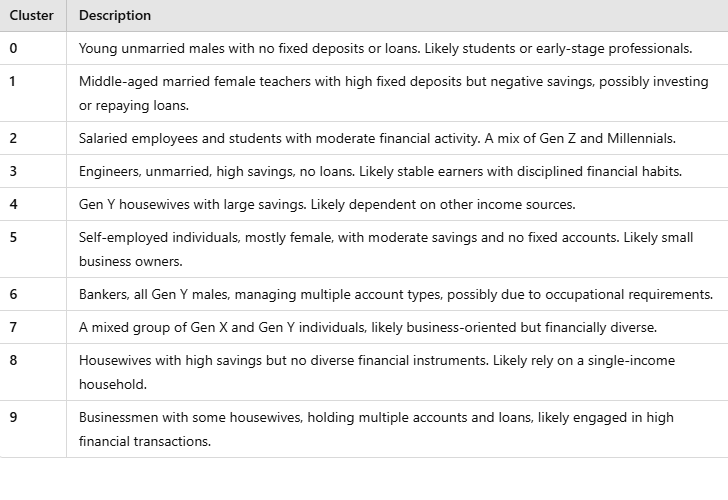